# First examples using xgcms new `transform` method.

In [1]:
from xgcm import Grid
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Linear transformation

In [170]:
# create a simple test dataset

z = np.arange(2, 12)
data = xr.DataArray(np.flip(np.log(z)*0.5+ np.random.rand(len(z))), dims=['depth'], coords={'depth':z})
target_data = xr.DataArray(np.log(z), dims=['depth'], coords={'depth':z})
# try with linear density

ds = xr.Dataset({'data':data, 'dens':target_data})
ds

<xarray.Dataset>
Dimensions:  (depth: 10)
Coordinates:
  * depth    (depth) int64 2 3 4 5 6 7 8 9 10 11
Data variables:
    data     (depth) float64 1.8 1.687 1.126 1.615 ... 1.527 1.357 1.076 0.5951
    dens     (depth) float64 0.6931 1.099 1.386 1.609 ... 2.197 2.303 2.398

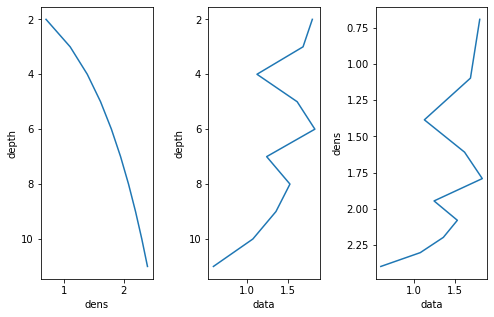

In [171]:
# Plot the data in depth and density

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.dens.plot(ax=ax1, y='depth', yincrease=False)
ds.data.plot(ax=ax2, y='depth', yincrease=False)
ax3.plot(ds.data, ds.dens, )
ax3.set_ylabel('dens')
ax3.set_xlabel('data')
ax3.yaxis.set_inverted(True)
fig.subplots_adjust(wspace=0.5)

Ok now lets transform `data` to `dens` coordinates using linear interpolation.

In [172]:
# First create a grid object

grid = Grid(ds, coords={'Z':{'center':'depth'}}, periodic=False)

# define the target values in density
target_values = np.linspace(0,3, 20)

# and transform
transformed = grid.transform(ds.data, 'Z', target_values, target_data=ds.dens)
transformed

<xarray.DataArray (dens: 20)>
array([1.80015343, 1.80015343, 1.80015343, 1.80015343, 1.80015343,
       1.77329338, 1.72926542, 1.67411243, 1.36597123, 1.20193666,
       1.54842181, 1.76614468, 1.43867897, 1.47042539, 1.32149262,
       0.74372398, 0.59507915, 0.59507915, 0.59507915, 0.59507915])
Coordinates:
  * dens     (dens) float64 0.0 0.1579 0.3158 0.4737 ... 2.526 2.684 2.842 3.0

Ok lets compare the output...

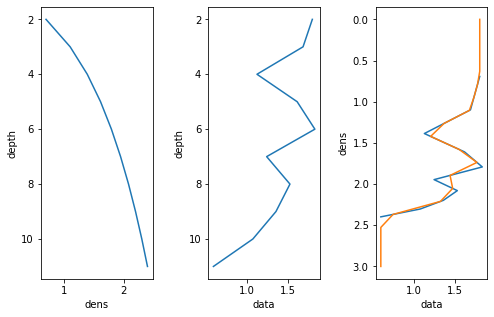

In [173]:
# Plot the data in depth and density

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.dens.plot(ax=ax1, y='depth', yincrease=False)
ds.data.plot(ax=ax2, y='depth', yincrease=False)
ax3.plot(ds.data, ds.dens, )
transformed.plot(ax=ax3, y='dens',yincrease=False)
ax3.set_ylabel('dens')
ax3.set_xlabel('data')
ax3.yaxis.set_inverted(True)


fig.subplots_adjust(wspace=0.5)

Not too bad. We can increase the number of interpolation levels to capture more of the small scale structure.

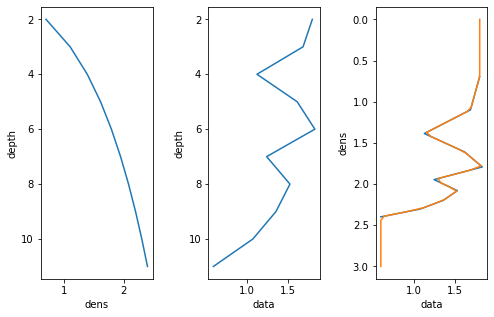

In [174]:
# define the target values in density
target_values = np.linspace(0,3, 60)

# and transform
transformed = grid.transform(ds.data, 'Z', target_values, target_data=ds.dens)

# Plot the data in depth and density
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.dens.plot(ax=ax1, y='depth', yincrease=False)
ds.data.plot(ax=ax2, y='depth', yincrease=False)
ax3.plot(ds.data, ds.dens, )
transformed.plot(ax=ax3, y='dens',yincrease=False)
ax3.set_ylabel('dens')
ax3.set_xlabel('data')
ax3.yaxis.set_inverted(True)


fig.subplots_adjust(wspace=0.5)

Note that by default, the edge values which are interpolated to values that do not exist in the `target_data` array are just repeating the last valid value. To mask these values, you can pass `mask_edges=True`:

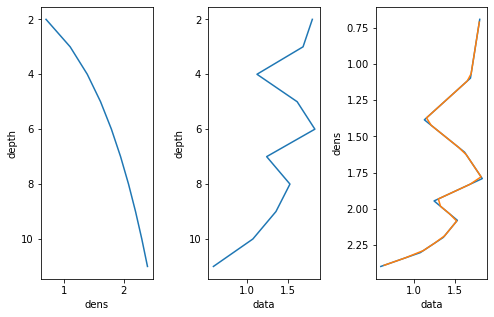

In [175]:
# define the target values in density
target_values = np.linspace(0,3, 60)

# and transform
transformed = grid.transform(ds.data, 'Z', target_values, target_data=ds.dens, mask_edges=True)

# Plot the data in depth and density
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.dens.plot(ax=ax1, y='depth', yincrease=False)
ds.data.plot(ax=ax2, y='depth', yincrease=False)
ax3.plot(ds.data, ds.dens, )
transformed.plot(ax=ax3, y='dens',yincrease=False)
ax3.set_ylabel('dens')
ax3.set_xlabel('data')
ax3.yaxis.set_inverted(True)


fig.subplots_adjust(wspace=0.5)

Nice. Now lets have a look at the `conservative` method.

## Conservative transformation
The conservative method requires more input data at the moment. You have to not only specify the location of the cell centers, but also the cell faces (or bounds/boundaries). In xgcm we achieve this by defining the bounding coordinates as `outer` coordinate. 
> This method will currently not work with `left`/`right` coordinates

In [176]:
# define the cell bounds in depth
zc = np.arange(1,12)+0.5
#add them to the existing dataset
ds = ds.assign_coords({'depth_bounds':zc})

# Recreate the grid object with a staggered `center`/`outer` coordinate layout

grid = Grid(ds, coords={'Z':{'center':'depth', 'outer':'depth_bounds'}},
            periodic=False)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   depth --> outer
  * outer    depth_bounds --> center

In [177]:
ds

<xarray.Dataset>
Dimensions:       (depth: 10, depth_bounds: 11)
Coordinates:
  * depth         (depth) int64 2 3 4 5 6 7 8 9 10 11
  * depth_bounds  (depth_bounds) float64 1.5 2.5 3.5 4.5 ... 8.5 9.5 10.5 11.5
Data variables:
    data          (depth) float64 1.8 1.687 1.126 1.615 ... 1.357 1.076 0.5951
    dens          (depth) float64 0.6931 1.099 1.386 1.609 ... 2.197 2.303 2.398

Currently the `target_data`(`dens` in this case) has to be located on the `outer` coordinate for the conservative method (compared to the `center` for the linear method).

We can easily interpolate `dens` on the outer coordinate with the grid object

> We will work on this so that we can interpolate internally.

In [178]:
ds['dens_outer'] = grid.interp(ds.dens, 'Z', boundary='fill')
ds['dens_outer']

<xarray.DataArray 'dens_outer' (depth_bounds: 11)>
array([0.34657359, 0.89587973, 1.24245332, 1.49786614, 1.70059869,
       1.86883481, 2.01267585, 2.13833306, 2.24990484, 2.35024018,
       1.19894764])
Coordinates:
  * depth_bounds  (depth_bounds) float64 1.5 2.5 3.5 4.5 ... 8.5 9.5 10.5 11.5

Now lets transform the data using the conservative method. Note that the target values will now be interpreted as cell bounds and not cell centers as before.

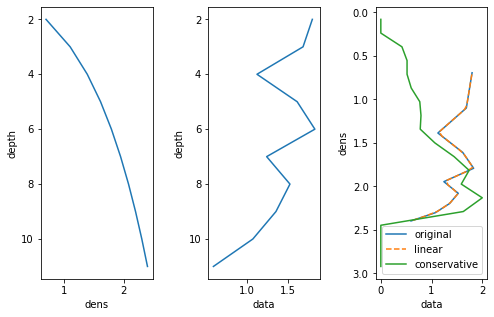

In [179]:
# define the target values in density
target_values = np.linspace(0,3, 20)

# and transform
transformed_cons = grid.transform(ds.data,
                                  'Z',
                                  target_values,
                                  method='conservative',
                                  target_data=ds.dens_outer)

# Plot the data in depth and density
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.dens.plot(ax=ax1, y='depth', yincrease=False)
ds.data.plot(ax=ax2, y='depth', yincrease=False)
ax3.plot(ds.data, ds.dens, )
transformed.plot(ax=ax3, y='dens',yincrease=False, ls='--')
transformed_cons.plot(ax=ax3, y='dens_outer',yincrease=False)
ax3.set_ylabel('dens')
ax3.set_xlabel('data')
ax3.yaxis.set_inverted(True)
ax3.legend(['original', 'linear', 'conservative'])


fig.subplots_adjust(wspace=0.5)

Since we are workign with extensive quantities, the graph does not look very similar (it would be better to convert to intensive quantities and then plot), but the column integral is conserved.

In [180]:
ds.data.sum()

<xarray.DataArray 'data' ()>
array(13.85826044)

In [181]:
transformed_cons.sum()

<xarray.DataArray ()>
array(13.85826044)

So for a better visual comparison lets convert to intensive data:

In [182]:
dz = ds.depth_bounds.diff('depth_bounds').data

dz_dens = grid.transform(ds.depth, 'Z', target_values, target_data=ds.dens).diff('dens').rename({'dens':'dens_outer'})
dz_dens = dz_dens.where(~np.isclose(dz_dens, 0.0)).data
dz_dens
dz

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [183]:
ds.data/dz

<xarray.DataArray 'data' (depth: 10)>
array([1.80015343, 1.68709201, 1.1256629 , 1.61533044, 1.8311529 ,
       1.24364399, 1.52739615, 1.35700058, 1.07574889, 0.59507915])
Coordinates:
  * depth    (depth) int64 2 3 4 5 6 7 8 9 10 11

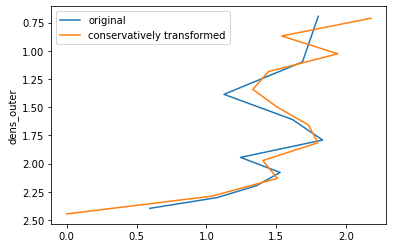

In [184]:
plt.plot(ds.data/dz, ds.dens)
(transformed_cons/dz_dens).plot(y='dens_outer', yincrease=False)

plt.legend(['original', 'conservatively transformed'])

BINGO!